# Using the `KNNClassifier`

This notebook aims to showcase how Sequentia's implementation of a $k$-NN classifier based on the dynamic time warping distance measure can be used in a typical sequence classisfication task. 

In particular, we look at the [Free Spoken Digit Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset), which is an open dataset consisting of audio recordings of spoken digits from 0 to 9. We are interested in the task of determining which digit was spoken based on the audio recordings. Since audio signals are sequential data, we can consider this as a sequence classification problem.

In [1]:
import librosa
from torchfsdd import TorchFSDDGenerator

from sequentia.preprocessing import Compose, Standardize, Transform
from sequentia.classifiers import KNNClassifier

import matplotlib.pyplot as plt, numpy as np, pandas as pd, seaborn as sns

# Set seed for reproducible randomness
seed = 1
np.random.seed(seed)
rng = np.random.RandomState(seed)

To get started, we first decide to use [Mel-Frequency Cepstrum Coefficients (MFCCs)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), which are a common way to represent audio for machine learning. 

While there are methods that work directly with raw signals, the most common approach is to use transformed features such as MFCCs.

In short, MFCCs are used to characterize a particular window (usually 20-40ms) of samples of the original signal, by applying signal processing techniques and transformations to obtain a number of representative coefficients. The signal is divided into windows (which may be overlapping), and MFCCs are computed for each one of these frames.

Below, we specify 5 MFCCs along with a number of other configurations for the MFCCs.

**Note**: 5 MFCCs is far less than what would be used in typical machine learning tasks, but we use a small number just for demonstration purposes.<br/>However, we later see that the classifier takes quite long, even with just 5 MFCCs.

In [2]:
# Set MFCC configuration
sr = 8000
n_mfcc = 5
spec_kwargs = {'n_fft': 1024, 'hop_length': 256, 'power': 2}

# Set number of classes
n_digits = 10

The below code uses the [`torchfsdd`](https://github.com/eonu/torch-fsdd) package to load a local copy of the FSDD dataset into training and test set splits (80% and 20%, respectively).

Unlike typical batch loading used with PyTorch, this classifier requires all data to be loaded into memory at once, which is why we use `load_all=True`.

In [3]:
# Initialize a generator for a local version of FSDD, loading all recordings into memory
fsdd = TorchFSDDGenerator(version='local', path='recordings', load_all=True)

# Create two Torch datasets for a train-test split from the generator
train_set, test_set = fsdd.train_test_split(test_size=0.2)
print('Training set size: {}'.format(len(train_set)))
print('Test set size: {}'.format(len(test_set)))

Training set size: 2400
Test set size: 600


Since `torchfsdd` is intended for creating PyTorch dataset splits, we have to convert these into Numpy arrays.

In [4]:
# Convert Torch tensors to Numpy arrays
X_train = [x.detach().cpu().numpy().flatten() for x in train_set.recordings]
X_test = [x.detach().cpu().numpy().flatten() for x in test_set.recordings]

Next, we create a transformation that generates MFCCs.

In [5]:
class MFCC(Transform):
    def __init__(self, sr, n_mfcc, spec_kwargs):
        super().__init__()
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.spec_kwargs = spec_kwargs
        
    def transform(self, x):
        # Flatten to 1D Numpy array
        x = x.flatten()
        # Generate MFCCs
        x = librosa.feature.mfcc(x, sr=self.sr, n_mfcc=self.n_mfcc+1, **self.spec_kwargs)
        # Remove the first MFCC as it is a constant offset
        x = x[1:]
        # Transpose to TxD
        return x.T
    
    def __str__(self):
        return 'Generate {} MFCCs with sample rate {}'.format(self.n_mfcc, self.sr)

We now define a transformation pipeline that generates and standardizes MFCCs using the above class and the `Standardize` transformation from Sequentia. This sequence of transformations is packaged into a `Compose` class, which acts in a similar way as [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Compose).

In [6]:
# Create preprocessing pipeline
transforms = Compose([
    MFCC(sr, n_mfcc, spec_kwargs),
    Standardize()
])

transforms.summary()

                   Preprocessing summary:                   
1. MFCC
   Generate 5 MFCCs with sample rate 8000
------------------------------------------------------------
2. Standardize
   Standard scaling (zero mean, unit variance) (independent)


We apply the same transformations to both the training and test sets.

In [7]:
mfcc_train = transforms(X_train)
mfcc_test = transforms(X_test)

The figure below shows the difference between the raw audio signal of the pronunciation of a digit 3, and the MFCC representation.

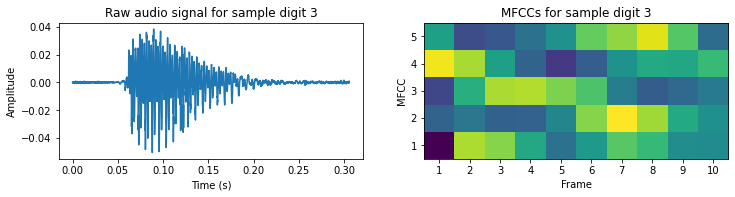

In [8]:
mfcc, digit = mfcc_train[0], train_set.labels[0]
audio, _ = librosa.load(train_set.files[0], sr=sr)
time = np.linspace(0, len(audio) / sr, num=len(audio))

# Raw audio
fig, axs = plt.subplots(ncols=2, figsize=(12, 2.5))
axs[0].set(title='Raw audio signal for sample digit {}'.format(digit), xlabel='Time (s)', ylabel='Amplitude')
axs[0].plot(time, audio)

# MFCCs
axs[1].imshow(np.swapaxes(mfcc, 0, 1), interpolation='nearest', cmap='viridis', origin='lower', aspect='auto')
axs[1].set(title='MFCCs for sample digit {}'.format(digit), xlabel='Frame', ylabel='MFCC',
    xticks=np.arange(len(mfcc)), xticklabels=np.arange(1, len(mfcc) + 1),
    yticks=np.arange(n_mfcc), yticklabels=np.arange(1, n_mfcc + 1))

plt.show()

Now we create and 'fit' our $k$-NN classifier on the training data. We demonstrate the use of a custom distance weighting function, a constrained warping window, along with independent warping and fast C compiled functions provided by [`dtaidistance`](https://github.com/wannesm/dtaidistance) to speed up the dynamic time warping calculations.

In [26]:
# Create and fit a kNN classifier using the single nearest neighbor
clf = KNNClassifier(k=1, classes=range(10), 
    weighting=(lambda x: np.exp(-x)), window=0.2, 
    use_c=True, independent=True)
clf.fit(mfcc_train, train_set.labels)

Evaluating the model on the test set, we can see that even with the above specifications and using multiple jobs, $k$-NN still suffers from being a much slower classifier compared to others, especially when the training set is large.

In [17]:
%%time

clf.predict(mfcc_test[:50], original_labels=True, verbose=True, n_jobs=1)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


Predicting:   0%|          | 0/50 [00:00<?, ?it/s]

array([5, 1, 3, 6, 4, 1, 7, 7, 8, 7, 6, 4, 0, 8, 4, 2, 0, 0, 4, 5, 3, 4,
       2, 9, 9, 2, 4, 3, 5, 3, 0, 2, 2, 1, 0, 8, 4, 6, 7, 6, 9, 7, 4, 4,
       6, 3, 5, 1, 1, 3])

In [35]:
%%time

clf.predict(mfcc_test[0], original_labels=True, verbose=True, n_jobs=1)

Calculating distances:   0%|          | 0/2400 [00:00<?, ?it/s]

CPU times: user 167 ms, sys: 13.4 ms, total: 180 ms
Wall time: 182 ms


5

In [ ]:
%%time

acc, cm = clf.evaluate(mfcc_test, test_set.labels, n_jobs=-1)

Though we still end up with very good results; even when just using a single neighbor!

In [ ]:
# Display accuracy and confusion matrix
labels = range(10)
df = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(7, 7))
sns.heatmap(df, annot=True, cbar=False)
plt.title('Confusion matrix for test set predictions', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print('Accuracy: {:.2f}%'.format(acc * 100))